In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [2]:
# Global Variables
english_sentences = []
hindi_sentences = []
translation_prob = defaultdict(lambda: defaultdict(float))
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = None

# i. Data Loading

In [3]:
def load_parallel_corpus(english_file='MediEng.txt', hindi_file='MediHn.txt'):
    global english_sentences, hindi_sentences, tfidf_matrix
    with open(english_file, 'r', encoding='utf-8') as f:
        english_sentences = [s.strip().lower() for s in f.readlines()]
    with open(hindi_file, 'r', encoding='utf-8') as f:
        hindi_sentences = [s.strip() for s in f.readlines()]

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(english_sentences)

# ii. Preprocessing

In [4]:
#Preprocess the sentences to remove punctuation and unwanted characters.
def preprocess_data():
    global english_sentences, hindi_sentences
    english_sentences = [s.translate(str.maketrans('', '', '.,!?')) for s in english_sentences]
    hindi_sentences = [s.translate(str.maketrans('', '', '।,!?')) for s in hindi_sentences]
    print("Data Preprocessed.")

# iii.EDA (Exploratory Data Analysis)

In [5]:
def eda():
    print("Performing EDA...")
    print(f"Number of English sentences: {len(english_sentences)}")
    print(f"Number of Hindi sentences: {len(hindi_sentences)}")
    
    # Length distribution of sentences
    english_lengths = [len(s.split()) for s in english_sentences]
    hindi_lengths = [len(s.split()) for s in hindi_sentences]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(english_lengths, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of English Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(hindi_lengths, bins=30, color='green', alpha=0.7)
    plt.title('Distribution of Hindi Sentence Lengths')
    plt.xlabel('Length (number of words)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Unique word counts
    english_words = [word for sent in english_sentences for word in word_tokenize(sent)]
    hindi_words = [word for sent in hindi_sentences for word in word_tokenize(sent)]
    
    unique_english_words = set(english_words)
    unique_hindi_words = set(hindi_words)

    print(f"Unique English Words: {len(unique_english_words)}")
    print(f"Unique Hindi Words: {len(unique_hindi_words)}")
    # Average sentence lengths
    avg_english_length = np.mean(english_lengths)
    avg_hindi_length = np.mean(hindi_lengths)
    
    print(f"Average English Sentence Length: {avg_english_length:.2f} words")
    print(f"Average Hindi Sentence Length: {avg_hindi_length:.2f} words")

    # Most common words
    common_english = Counter(english_words).most_common(10)
    common_hindi = Counter(hindi_words).most_common(10)
    
    print("Most Common English Words:")
    for word, count in common_english:
        print(f"{word}: {count}")

    print("\nMost Common Hindi Words:")
    for word, count in common_hindi:
        print(f"{word}: {count}")

    

# iv. Train Translation Probabilities

In [6]:
def train_translation_probabilities():
    global translation_prob
    word_pairs = defaultdict(lambda: defaultdict(int))
    english_counts = defaultdict(int)
    
    for eng_sent, hin_sent in zip(english_sentences, hindi_sentences):
        eng_words = word_tokenize(eng_sent)
        hin_words = word_tokenize(hin_sent)
        
        for eng_word in eng_words:
            english_counts[eng_word] += 1
            for hin_word in hin_words:
                word_pairs[eng_word][hin_word] += 1
    
    for eng_word in word_pairs:
        total = english_counts[eng_word]
        for hin_word in word_pairs[eng_word]:
            translation_prob[eng_word][hin_word] = word_pairs[eng_word][hin_word] / total
    print("Translation Probabilities Trained.")

# v. Statistical Machine Translation

In [7]:
def translate(english_sentence):
    english_sentence = english_sentence.strip().lower()
    input_vector = tfidf_vectorizer.transform([english_sentence])
    similarities = cosine_similarity(input_vector, tfidf_matrix)[0]
    
    best_match_index = np.argmax(similarities)
    best_match_score = similarities[best_match_index]
    
    if best_match_score < 0.5:
        eng_words = word_tokenize(english_sentence)
        hindi_words = []
        
        for eng_word in eng_words:
            best_prob = 0
            best_word = eng_word
            for hin_word, prob in translation_prob[eng_word].items():
                if prob > best_prob:
                    best_prob = prob
                    best_word = hin_word
            hindi_words.append(best_word)
        return " ".join(hindi_words)
    
    return hindi_sentences[best_match_index]

# vi. Evaluation Metrics

In [8]:
def evaluate_performance(test_english_file='test.en', test_hindi_file='test.hi'):
    """Evaluate model performance with BLEU, Word Overlap, Length Ratio, and Similarity."""
    with open(test_english_file, 'r', encoding='utf-8') as f:
        test_eng = [s.strip().lower() for s in f.readlines()]
    with open(test_hindi_file, 'r', encoding='utf-8') as f:
        test_hin = [s.strip() for s in f.readlines()]

    bleu_scores, word_overlap_scores, length_ratios, similarity_scores = [], [], [], []
    smoothing = SmoothingFunction().method1

    for eng_sent, reference in zip(test_eng, test_hin):
        translation = translate(eng_sent)
        
        # BLEU score
        reference_tokens = [word_tokenize(reference)]
        translation_tokens = word_tokenize(translation)
        bleu = sentence_bleu(reference_tokens, translation_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)
        
        # Word overlap
        ref_words = set(word_tokenize(reference))
        trans_words = set(word_tokenize(translation))
        overlap = len(ref_words.intersection(trans_words)) / len(ref_words)
        word_overlap_scores.append(overlap)
        
        # Length ratio
        length_ratio = len(translation_tokens) / len(reference_tokens[0])
        length_ratios.append(length_ratio)
        
        # Similarity score
        ref_vector = tfidf_vectorizer.transform([reference])
        trans_vector = tfidf_vectorizer.transform([translation])
        similarity = cosine_similarity(ref_vector, trans_vector)[0][0]
        similarity_scores.append(similarity)

    # Aggregate metrics
    metrics = {
        'BLEU Score': {
            'Mean': np.mean(bleu_scores),
            'Median': np.median(bleu_scores),
            'Std Dev': np.std(bleu_scores)
        },
        'Word Overlap': {
            'Mean': np.mean(word_overlap_scores),
            'Median': np.median(word_overlap_scores),
            'Std Dev': np.std(word_overlap_scores)
        },
        'Length Ratio': {
            'Mean': np.mean(length_ratios),
            'Median': np.median(length_ratios),
            'Std Dev': np.std(length_ratios)
        },
        'Similarity Score': {
            'Mean': np.mean(similarity_scores),
            'Median': np.median(similarity_scores),
            'Std Dev': np.std(similarity_scores)
        },
    }
    return metrics


In [9]:
def plot_evaluation_metrics(metrics):
    for metric, values in metrics.items():
        plt.figure(figsize=(8, 4))
        plt.bar(values.keys(), values.values(), color=['blue', 'green', 'orange'])
        plt.title(f'{metric} Evaluation')
        plt.ylabel(metric)
        plt.show()

# Main Execution

Data Preprocessed.
Performing EDA...
Number of English sentences: 50002
Number of Hindi sentences: 50002


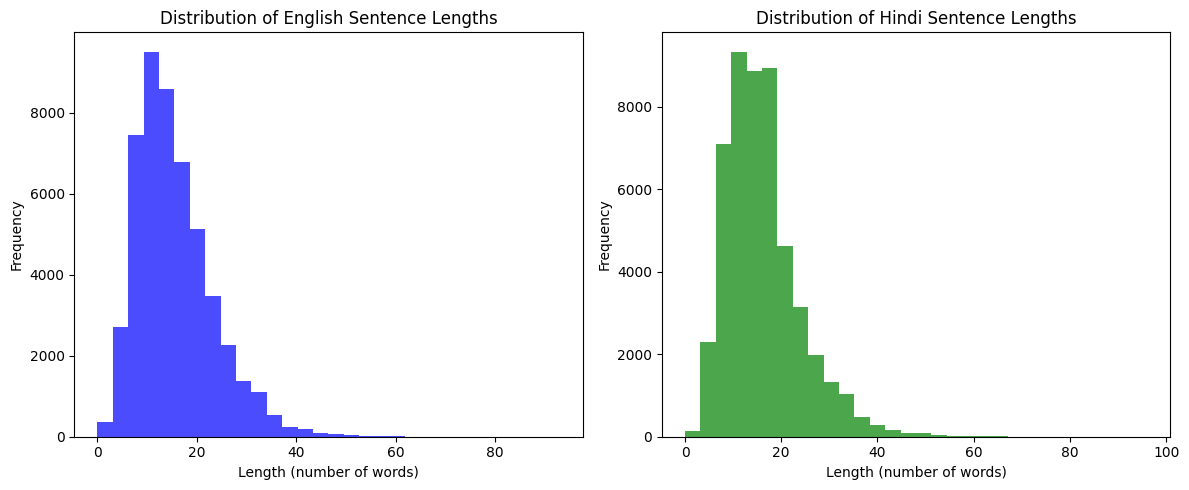

Unique English Words: 32009
Unique Hindi Words: 43013
Average English Sentence Length: 15.64 words
Average Hindi Sentence Length: 16.05 words
Most Common English Words:
the: 51282
of: 41320
in: 24282
is: 20457
and: 17969
to: 13137
a: 11101
this: 8441
on: 6927
are: 6666

Most Common Hindi Words:
है: 33960
के: 30287
में: 26230
से: 19712
की: 19119
का: 14134
हैं: 13290
को: 10939
और: 10109
पर: 8571
Translation Probabilities Trained.
English: Yoganidra - the main cause of this problem is mental tension and sentimental imbalance .
Hindi: योगनिद्रा - इस समस्या का मूल कारण मानसिक तनाव तथा भावनात्मक असंतुलन है 

--- Evaluation Metrics ---
BLEU Score:
  Mean: 0.8625
  Median: 0.8948
  Std Dev: 0.1198

Word Overlap:
  Mean: 0.8983
  Median: 0.9091
  Std Dev: 0.0495

Length Ratio:
  Mean: 0.8982
  Median: 0.9091
  Std Dev: 0.0515

Similarity Score:
  Mean: 0.5050
  Median: 1.0000
  Std Dev: 0.5000



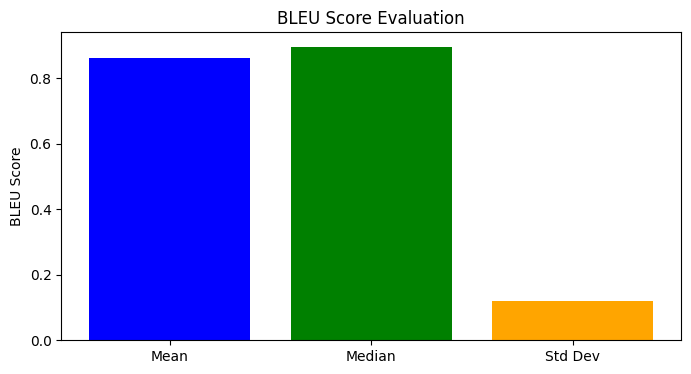

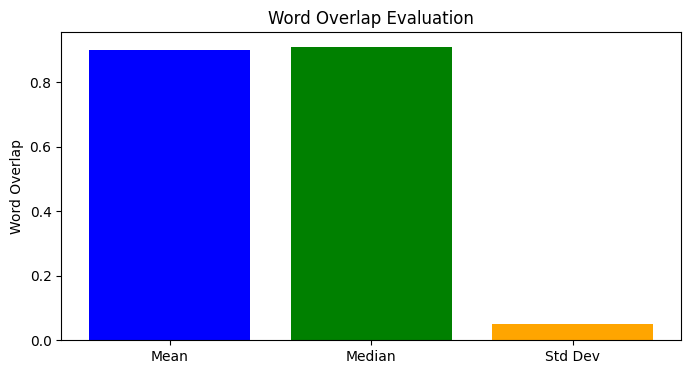

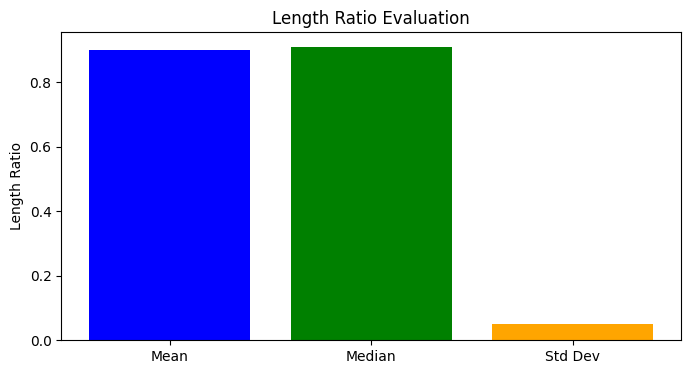

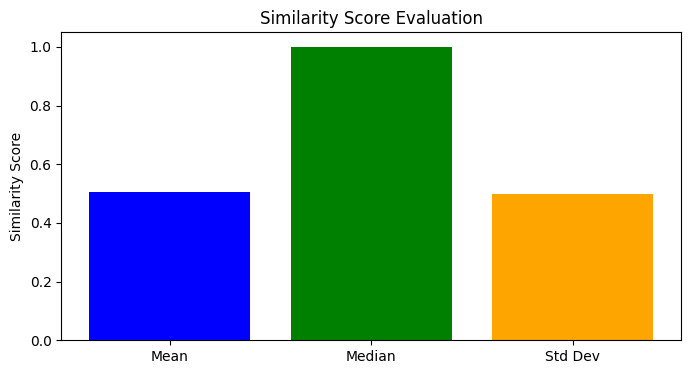

In [10]:
def main():
    load_parallel_corpus()
    preprocess_data()
    eda()
    train_translation_probabilities()

    # Example translation and evaluation
    test_sentence = "Yoganidra - the main cause of this problem is mental tension and sentimental imbalance ."
    hindi_translation = translate(test_sentence)
    print(f"English: {test_sentence}\nHindi: {hindi_translation}")

    # Evaluate Performance
    metrics = evaluate_performance()
    print("\n--- Evaluation Metrics ---")
    for metric, values in metrics.items():
        print(f"{metric}:")
        print(f"  Mean: {values['Mean']:.4f}")
        print(f"  Median: {values['Median']:.4f}")
        print(f"  Std Dev: {values['Std Dev']:.4f}")
        print()

    # Plot Evaluation Metrics
    plot_evaluation_metrics(metrics)

# Uncomment the line below to run the main function
# main()
if __name__ == '__main__':
    main()

In [11]:
test_sentence = "They increase the flow of oxygen in body and brain with which the activeness of brain increases "
hindi_translation = translate(test_sentence)
print("English:", test_sentence,"\nHindi:", hindi_translation)

English: They increase the flow of oxygen in body and brain with which the activeness of brain increases  
Hindi: ये शरीर और दिमाग में आक्सीजन का प्रवाह बढ़ाते हैं जिससे दिमाग की सक्रियता बढ़ती है 


In [12]:
# Evaluate Performance
metrics = evaluate_performance()
print("======Evaluation Metrics======")
for metric, values in metrics.items():
    print(metric)
    print("Mean value is: ",values['Mean'])
    print("Median value i: ",values['Median'])
    print("Std value i: ",values['Std Dev'])
    print()

======Evaluation Metrics======
BLEU Score
Mean value is:  0.8625427050513579
Median value i:  0.8948393168143697
Std value i:  0.11980726879745932

Word Overlap
Mean value is:  0.8983266696475423
Median value i:  0.9090909090909091
Std value i:  0.049468835907355985

Length Ratio
Mean value is:  0.8981679009169761
Median value i:  0.9090909090909091
Std value i:  0.051501693593784224

Similarity Score
Mean value is:  0.505
Median value i:  1.0
Std value i:  0.49997499937496875



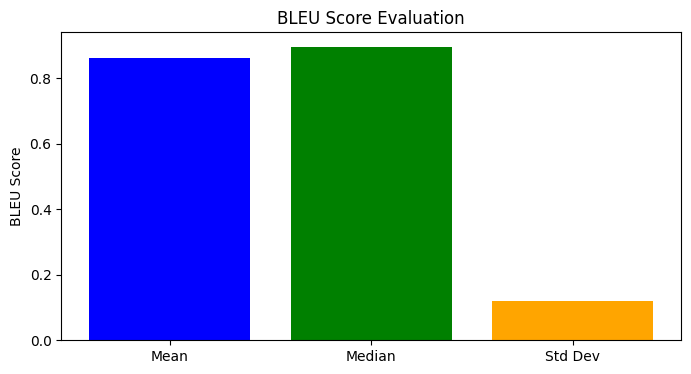

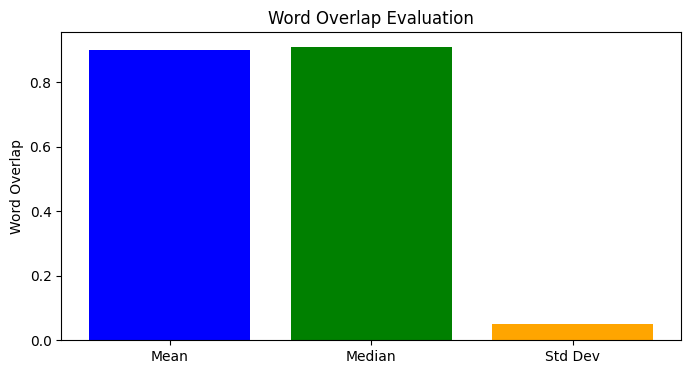

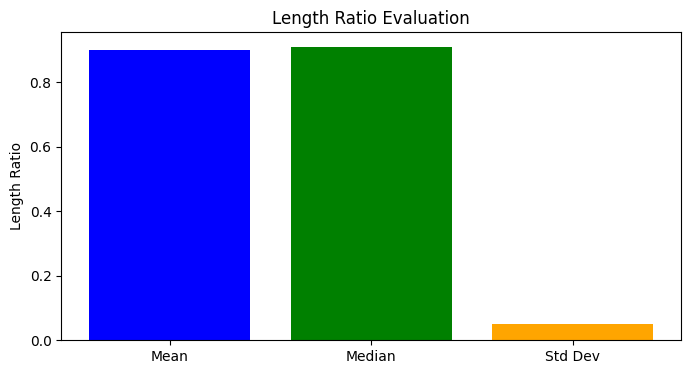

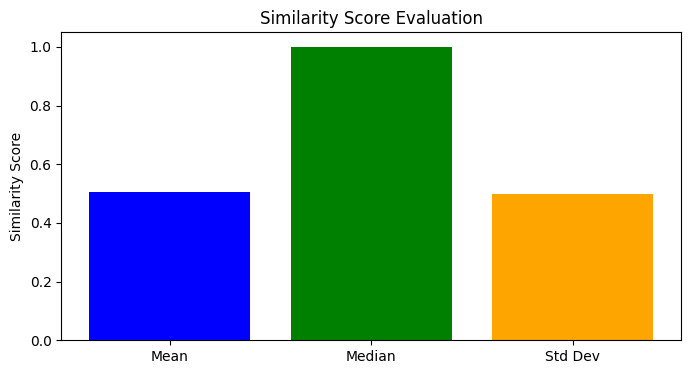

In [13]:
plot_evaluation_metrics(metrics)